In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

## Define random Seed and Ignore Warnnings

In [2]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

## Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install pydicom library to read DICOM files

In [4]:
def installPlugggins():
  !pip install pydicom
  !pip install -q git+https://github.com/tensorflow/docs

In [5]:
installPlugggins()

     |████████████████████████████████| 1.9MB 7.0MB/s 
     |████████████████████████████████| 1.0MB 5.4MB/s 


##Import basic Libraries

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
import os
from zipfile import ZipFile
import matplotlib.patches as patches
import time
import datetime
import shutil
import csv
import random
from skimage import io
from skimage import measure
from skimage.transform import resize

###Data Augmentation

In [7]:
%cd '/content/drive/My Drive/pgp/Projects/capstone/'

/content/drive/My Drive/pgp/Projects/capstone


In [8]:
train_path = '/content/drive/My Drive/pgp/Projects/capstone/data/dicom_train_images/'
test_path = '/content/drive/My Drive/pgp/Projects/capstone/data/dicom_test_images'
class_path = '/content/drive/My Drive/pgp/Projects/capstone/data/stage_2_detailed_class_info.csv'
label_path = '/content/drive/My Drive/pgp/Projects/capstone/data/stage_2_train_labels.csv'

In [9]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import cv2
import tensorflow.keras

from keras.utils import np_utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Reshape, UpSampling2D,BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD , RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [10]:
def getPneumoniaBbLocations(train_label_file_path, filenames):
  pneumonia_locations = {}
  # load table
  with open(train_label_file_path, mode='r') as infile:
      # open reader
      reader = csv.reader(infile)
      # skip header
      next(reader, None)
      # loop through rows
      for rows in reader:
          # retrieve information
          patientId = rows[0]
          location = rows[1:5]
          pneumonia = rows[5]
          # if row contains pneumonia add label to dictionary
          # which contains a list of pneumonia locations per filename
          filename = patientId+'.dcm'
          if filename in filenames and pneumonia == '1':
              # convert string to float to int
              location = [int(float(i)) for i in location]
              # save pneumonia location in dictionary
              if patientId in pneumonia_locations:
                  pneumonia_locations[patientId].append(location)
              else:
                  pneumonia_locations[patientId] = [location]
  return pneumonia_locations

In [12]:
# Creates directory, if directory exists removes if remove parameter is set to True
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
    return True

# Removes directory, if directory exists


def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    return True


def clear_directory(directory_path):
    if os.path.exists(directory_path):
        dirs_files = os.listdir(directory_path)
        for item in dirs_files:
            item_path = directory_path + item
            try:
                if os.path.isfile(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
            except Exception as e:
                print(e)

    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return

    # remove empty subfolders
    files = os.listdir(path)

    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)

            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)

    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


def model_watch_directory(main_model_dir, main_log_dir):
    clear_directory(main_log_dir)
    remove_empty_folders(main_model_dir, False)

    model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S')
    log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

    create_directory(model_dir, remove=True)
    create_directory(log_dir, remove=True)

    model_file = model_dir + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"
    return (model_dir, log_dir, model_file)


In [13]:
def get_callbacks(checkpoint_path, log_dir, monitor):
  checkpoint = ModelCheckpoint(
    filepath = checkpoint_path, 
    monitor='val_accuracy', 
    save_best_only=True)

  early_stopping = EarlyStopping(
    monitor= monitor,
    patience=5,
    verbose=1,
    restore_best_weights=True)


  tensorboard = TensorBoard(
    log_dir=log_dir,
    update_freq = 'batch')


  reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)
  
  callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
  return callbacks

def get_optimizer():
  return tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=1e-08)

def compile_model(model, optimizer):
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics=['accuracy']

  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=loss,
                metrics= metrics)

  model.summary()

In [14]:
def fit_model(model, train_gen, validation_data, model_file, log_dir, monitor='val_loss', max_epochs=10):
    steps_per_epoch=len(train_gen)
    validation_steps=len(validation_data)
    history = model.fit(
        train_gen,
        steps_per_epoch = steps_per_epoch,
        validation_data=validation_data,
        validation_steps=validation_steps, 
        callbacks= get_callbacks(model_file, log_dir, monitor),
        epochs=max_epochs,
        shuffle=True,
        verbose=2)
    return history

In [49]:
class DataGenerator(tensorflow.keras.utils.Sequence):

    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()

    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size),
                     mode='reflect') > 0.3
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk

    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img

    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index *
                                   self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)


In [16]:
def get_training_data(df_labels, count):
  positive_count = int(count*0.5)

  pneumonio_patients = df_labels[df_labels['Target'] == 1]['patientId'].unique()
  normal_patients = df_labels[df_labels['Target'] == 0]['patientId'].unique()
  
  if(positive_count > len(pneumonio_patients)):
    positive_count = len(pneumonio_patients)

  positive_selection_index = np.random.choice(len(pneumonio_patients), positive_count, replace=False)
  positive_selection = pneumonio_patients[positive_selection_index]

  negative_count = count - len(positive_selection)
  negative_selection_index = np.random.choice(len(normal_patients), negative_count, replace=False)
  negative_selection = normal_patients[negative_selection_index]

  print(f'Pneumonia: {len(positive_selection)}')
  print(f'Normal: {len(negative_selection)}')
  
  patients = np.concatenate([positive_selection,negative_selection])
  random.shuffle(patients)

  filenames = list(map(lambda id: id+'.dcm', patients))
  
  return filenames

In [17]:
df_labels = pd.read_csv(label_path)
#Sample No Pneumonia case
df_labels.head(1)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


In [88]:
#valid_patientsIds = list(map(lambda filename: filename.split(".")[0], valid_filenames))
#df_labels[(df_labels['patientId'].isin(valid_patientsIds)) & df_labels['Target'] == 1]

In [25]:
#dicom_file_names_path = './data/dicom_file_names.txt'
#filenames = os.listdir(train_path)
# with open(dicom_file_names_path, "w") as f:
#     for s in filenames:
#         f.write(s +"\n")

In [18]:
selected_files = get_training_data(df_labels, 1000)
print(f'{len(selected_files)}, names:{selected_files[0]}')
dicom_file_names_path = './data/dicom_file_names.txt'

filenames = []
with open(dicom_file_names_path, "r") as f:
  for line in f:
    filenames.append(line.strip())

print(f'Selected files sbset of filenames ? : {set(selected_files).issubset(filenames)}')

Pneumonia: 500
Normal: 500
1000, names:afa95e84-6a86-4203-ad3c-f3adb8aaaa03.dcm
Selected files sbset of filenames ? : True


In [19]:
pneumonia_locations = getPneumoniaBbLocations(label_path, filenames)
#pneumonia_locations

In [57]:
#pneumonia_locations

In [20]:
def split_train_test(validation_split, filenames, pneumonia_locations):
  random.shuffle(filenames)
  # split into train and validation filenames
  n_valid_samples = int(len(filenames)*validation_split)
  train_filenames = filenames[n_valid_samples:]
  valid_filenames = filenames[:n_valid_samples]
  print('n train samples', len(train_filenames))
  print('n valid samples', len(valid_filenames))
  n_train_samples = len(filenames) - n_valid_samples
  print('Total train images:',len(filenames))
  print('Images with pneumonia:', len(pneumonia_locations))
  return (train_filenames, valid_filenames)
(train_filenames, valid_filenames) = split_train_test( validation_split = 0.1, filenames = selected_files, pneumonia_locations = pneumonia_locations)

n train samples 900
n valid samples 100
Total train images: 1000
Images with pneumonia: 6012


In [31]:
model_output_dir = '/content/drive/My Drive/pgp/Projects/capstone/model_output_dir/'
main_model_dir = model_output_dir + r"models/"
main_log_dir = model_output_dir + r"logs/"
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(128,128,1)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (1, 1), padding="valid", activation='relu'))
    model.add(Conv2D(1, 1, activation='sigmoid'))
    model.add(UpSampling2D(64))
    #model.add(Reshape((4,)))
    model.add(Dense(1, activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(Dense(4 , activation='softmax'))
    
    return model

In [45]:
TARGET_IMAGE_SIZE = 128
model_output_dir = '/content/drive/My Drive/pgp/Projects/capstone/model_output_dir/inception/'
main_model_dir = model_output_dir + r"models/"
main_log_dir = model_output_dir + r"logs/"
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_inception_model():    
    img_input = tf.keras.layers.Input(shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE,1))
    img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=img_conc)

    x = base_model.output
    
    x = BatchNormalization()(x)
    x = tensorflow.keras.layers.LeakyReLU(0)(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = UpSampling2D(64)(x)

    #output = Dense(1, activation='sigmoid')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=output)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    return model

In [46]:
#model = get_conv_model()
model = get_inception_model()
print(f'Model input shape: {model.input.shape}');
print(f'Model output shape: {model.output.shape}')

Model input shape: (None, 128, 128, 1)
Model output shape: (None, 128, 128, 1)


In [47]:
optimizer=optimizers.Adam()
compile_model(model, optimizer)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 128, 128, 3)  0           input_5[0][0]                    
                                                                 input_5[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 63, 63, 32)   864         concatenate_12[0][0]             
_______________________________________________________________________________________

In [50]:
(model_dir, log_dir, model_file) = model_watch_directory(main_model_dir, main_log_dir)
print(log_dir)
log_file = log_dir+'/log'
print(model_file)

Removing empty folder: /content/drive/My Drive/pgp/Projects/capstone/model_output_dir/inception/models/2020-12-15 14-43-27
/content/drive/My Drive/pgp/Projects/capstone/model_output_dir/inception/logs/2020-12-15 14-45-04
/content/drive/My Drive/pgp/Projects/capstone/model_output_dir/inception/models/2020-12-15 14-45-04{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5


In [51]:
# Parameters
# params = {'dim': (32,32,32),
#           'batch_size': 64,
#           'n_classes': 6,
#           'n_channels': 1,
#           'shuffle': True}

# Generators
training_generator = DataGenerator(train_path, train_filenames, pneumonia_locations, augment=True, image_size=128)
validation_generator = DataGenerator(train_path, valid_filenames, pneumonia_locations, augment=True, image_size=128)

In [ ]:
#__init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=150, shuffle=True, augment=False, predict=False):

In [52]:
history = fit_model(model, training_generator, validation_generator, model_file, log_dir, monitor='val_loss', max_epochs=5)

Epoch 1/5
28/28 - 257s - loss: 0.7086 - accuracy: 0.9340 - val_loss: 0.6931 - val_accuracy: 0.9380
Epoch 2/5
28/28 - 275s - loss: 0.6933 - accuracy: 0.9422 - val_loss: 0.6931 - val_accuracy: 0.9309
Epoch 3/5
28/28 - 271s - loss: 0.6933 - accuracy: 0.9427 - val_loss: 0.6932 - val_accuracy: 0.9354
Epoch 4/5
28/28 - 264s - loss: 0.6933 - accuracy: 0.9423 - val_loss: 0.6932 - val_accuracy: 0.9312
Epoch 5/5
28/28 - 261s - loss: 0.6933 - accuracy: 0.9424 - val_loss: 0.6932 - val_accuracy: 0.9304


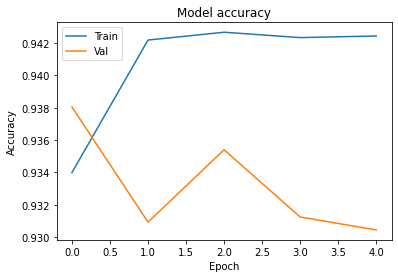

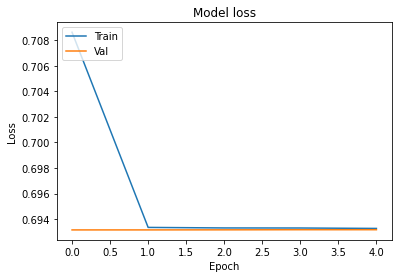

In [53]:

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [49]:
tmp_filename = '0ae5dcc7-197d-4d59-991a-3b93f3a1e760.dcm'
img = pydicom.dcmread(os.path.join(train_path, tmp_filename)).pixel_array
# create empty mask
msk = np.zeros(img.shape)
# get filename without extension
filename = tmp_filename.split('.')[0]
# if image contains pneumonia
if filename in pneumonia_locations:
    print('hello')
    # loop through pneumonia
    for location in pneumonia_locations[filename]:
        # add 1's at the location of the pneumonia
        x, y, w, h = location
        msk[y:y+h, x:x+w] = 1

In [ ]:
img = resize(img, (self.image_size, self.image_size), mode='reflect')
msk = resize(msk, (self.image_size, self.image_size),
              mode='reflect') > 0.5

In [75]:
imgs, msks = validation_generator[0]

In [76]:
img_pred = model.predict(imgs)

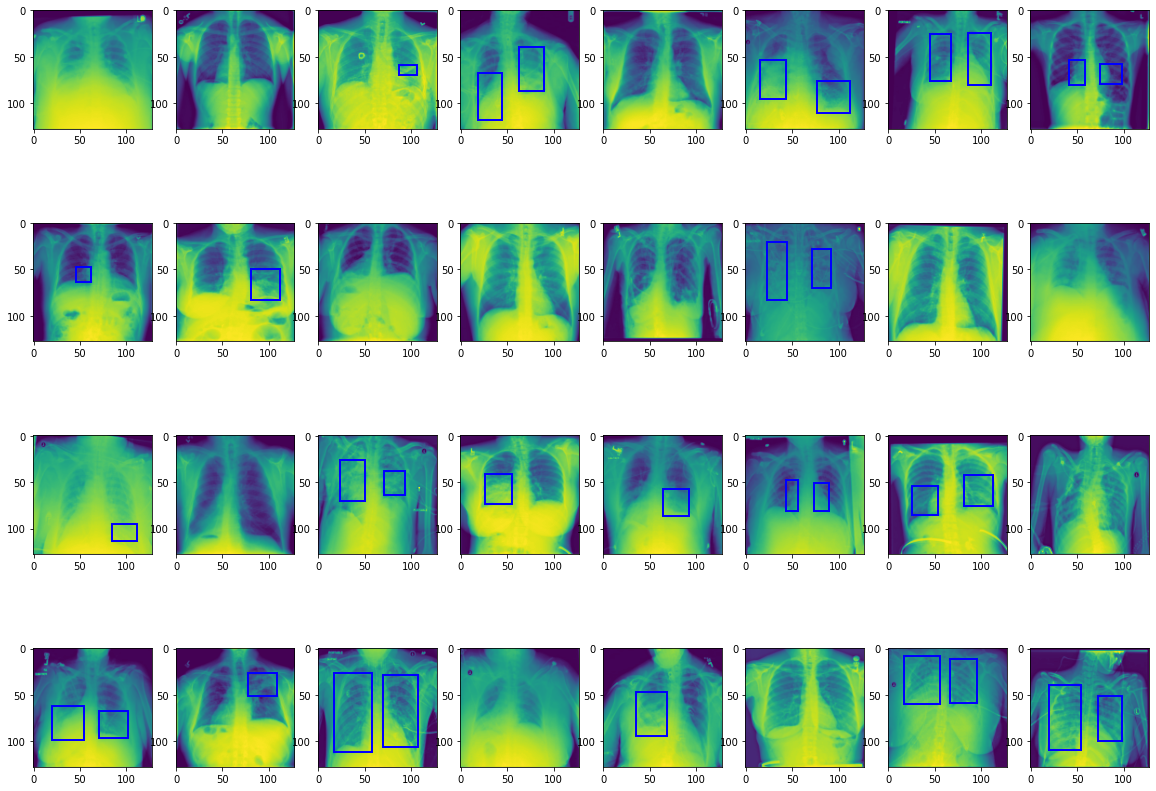

In [54]:
for imgs, msks in validation_generator:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.3
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            #print(f'x: {x},y: {y},h: {height}, w: {width}')
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.3
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            #print(f'x: {x},y: {y},h: {height}, w: {width}');
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break